In [ ]:
import os, sys, csv, json, subprocess, requests, pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Dict, Optional, Tuple
from tqdm import tqdm
from itertools import product

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, precision_recall_curve


sys.path.append("../..")
from proteomelm.ppi.model import prepare_ppi
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['text.usetex'] = False
plt.rcParams['font.size'] = 14

env_dir = "/data2/malbrank/proteomelm/interactomes/pathogens/"

/home/malbrank/Documents/ProteomeLM/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preparation of the data

1. **Utility Functions**:  
    Several helper functions are defined for tasks such as average product correction, batch fetching of UniProt and UniParc sequences, and mapping STRING-DB protein IDs to UniProt IDs using BLAST.

2. **Data Loading and Preprocessing**:  
    The protein-protein interaction pairs and their labels are loaded from an Excel file. Protein identifiers are extracted and organized for downstream mapping.

3. **Sequence Retrieval**:  
    Protein sequences are fetched from UniProt and UniParc in batches. Missing taxon IDs are handled using a supplementary CSV file, and all sequences are grouped by taxon for export.

4. **FASTA File Preparation**:  
    Protein sequences from UniProt and STRING-DB are exported into FASTA files, both per taxon and as combined files, to facilitate mapping and merging.

5. **ID Mapping and Sequence Merging**:  
    BLAST is used to map STRING protein IDs to UniProt accessions. Mappings are filtered by identity and coverage thresholds, and merged FASTA files are generated for each taxon using the established mappings.

6. **Label Matrix Construction**:  
    For each taxon, a label matrix is constructed to indicate known positive and negative protein-protein interactions, which is then flattened for model training.

In [2]:
def fetch_uniprot_sequences_batch(
    ids: List[str],
    batch_size: int = 100
) -> Dict[str, Tuple[str, int]]:
    """
    Fetches UniProtKB sequences in FASTA format given a list of accessions.

    Returns a dictionary mapping UniProt accession to (sequence, taxon ID).
    """
    url = "https://rest.uniprot.org/uniprotkb/stream"
    headers = {"Accept": "application/json"}
    sequences = {}
    ids = list(ids)

    for i in tqdm(range(0, len(ids), batch_size)):
        batch_ids = ids[i:i+batch_size]
        query = " OR ".join(f"accession:{pid}" for pid in batch_ids)
        params = {
            "query": query,
            "format": "json"
        }

        response = requests.get(url, params=params, headers=headers)

        if response.status_code == 200:
            data = response.json()
            for entry in data.get("results", []):
                accession = entry.get("primaryAccession")
                sequence = entry.get("sequence", {}).get("value", "")
                if accession and sequence:
                    sequences[accession] = sequence
        else:
            print(f"Failed batch {i//batch_size + 1}: {response.status_code} – {response.text}")
    
    return sequences

def fetch_uniparc_sequences_batch(
    uniprot_ids: List[str],
    batch_size: int = 1
) -> Dict[str, str]:
    """
    Fetches UniParc sequences by UniProt accessions using the UniParc API.

    Returns a dict mapping UniProt accessions to sequences.
    """
    base_url = "https://rest.uniprot.org/uniparc/search"
    headers = {"Accept": "application/json"}
    session = requests.Session()
    sequences: Dict[str, str] = {}

    for i in tqdm(range(0, len(uniprot_ids), batch_size), desc="Fetching UniParc sequences"):
        batch = uniprot_ids[i:i + batch_size]
        query = " OR ".join(batch)
        params = {"query": query, "format": "json", "size": 500}

        response = session.get(base_url, headers=headers, params=params)
        if response.status_code != 200:
            print(f"[ERROR] Failed to fetch batch {i // batch_size + 1}: {response.status_code}")
            continue

        for entry in response.json().get("results", []):
            accessions = entry.get("uniProtKBAccessions", [])
            sequence = entry.get("sequence", {}).get("value", "")
            if not accessions or not sequence:
                continue
            cleaned_accessions = [acc.split(".")[0] for acc in accessions]
            for acc in cleaned_accessions:
                if acc in batch:
                    sequences[acc] = sequence

    return sequences

def map_string_to_uniprot(
    fasta_uniprot: str,
    fasta_string: str,
    db_name: str = "uniprot_db",
    blast_output: str = "string_vs_uniprot.tsv",
    identity_thresh: float = 95.0,
    cov_thresh: float = 90.0,
    threads: int = 4,
    json_output: Optional[str] = None
) -> Dict[str, str]:
    """
    Maps STRING protein IDs to UniProt accessions using BLASTP alignment.

    Parameters:
    - fasta_uniprot: Path to UniProt FASTA file (target).
    - fasta_string: Path to STRING FASTA file (query).
    - db_name: Output prefix for BLAST DB.
    - blast_output: Output file for BLAST tabular results.
    - identity_thresh: Minimum % identity to retain hit.
    - cov_thresh: Minimum % query coverage to retain hit.
    - threads: Number of threads to use.
    - json_output: Optional path to save resulting mapping as JSON.

    Returns:
    - Dictionary mapping STRING IDs to UniProt IDs.
    """
    # 1. Create BLAST database
    subprocess.run([
        "makeblastdb", "-in", fasta_uniprot, "-dbtype", "prot", "-out", db_name
    ], check=True)

    # 2. Run BLASTP
    subprocess.run([
        "blastp",
        "-query", fasta_string,
        "-db", db_name,
        "-outfmt", "6 qseqid sseqid pident qcovs evalue bitscore",
        "-qcov_hsp_perc", str(cov_thresh),
        "-num_threads", str(threads),
        "-out", blast_output
    ], check=True)

    # 3. Parse BLAST output
    best_hits: Dict[str, Dict[str, float]] = {}
    with open(blast_output) as f:
        reader = csv.DictReader(f, fieldnames=[
            "qseqid", "sseqid", "pident", "qcovs", "evalue", "bitscore"
        ], delimiter="\t")
        for row in reader:
            pident = float(row["pident"])
            qcov = float(row["qcovs"])
            bitscore = float(row["bitscore"])
            if pident < identity_thresh or qcov < cov_thresh:
                continue
            qid = row["qseqid"]
            if qid not in best_hits or bitscore > best_hits[qid]["bitscore"]:
                best_hits[qid] = {
                    "uniprot_id": row["sseqid"],
                    "bitscore": bitscore
                }

    mapping = {q: hit["uniprot_id"] for q, hit in best_hits.items()}

    if json_output:
        with open(json_output, "w") as f:
            json.dump(mapping, f, indent=2)

    return mapping

def merge_sequences_with_mapping(taxon_fasta, string_fasta, mapping, output_fasta):
    """
    Merges sequences from a taxon FASTA file with those from a STRING FASTA file based on a mapping.
    
    Parameters:
    - taxon_fasta: Path to the taxon FASTA file.
    - string_fasta: Path to the STRING FASTA file.
    - mapping: Dictionary mapping STRING IDs to UniProt IDs.
    - output_fasta: Path to the output merged FASTA file.
    """
    labels = []
    sequences = []
    string_ids_to_ignore = []
    with open(taxon_fasta) as taxon_file, open(string_fasta) as string_file, open(output_fasta, "w") as out_file:
        taxon_seqs = {line[1:].strip(): next(taxon_file).strip() for line in taxon_file if line.startswith(">")}
        string_seqs = {line[1:].strip(): next(string_file).strip() for line in string_file if line.startswith(">")}
        for taxon_id, seq in taxon_seqs.items():
            if taxon_id in mapping:
                string_id = mapping[taxon_id]
                string_ids_to_ignore.append(string_id)
                labels.append(taxon_id)
                sequences.append(seq)
        for string_id, seq in string_seqs.items():
            if string_id in string_ids_to_ignore:
                continue
            labels.append(string_id)
            sequences.append(seq)
    with open(output_fasta, "w") as out_file:
        for label, sequence in zip(labels, sequences):
            out_file.write(f">{label}\n{sequence}\n")


In [3]:
df = pd.read_excel(f"{env_dir}/baker_paper_data.xlsx", sheet_name="step4_fig1b")
df["protein1"] = df["Pair"].str.split("_").str[0]
df["protein2"] = df["Pair"].str.split("_").str[1]

# Collect labelled pairs
labelled_pairs = dict()
for protein1, protein2, label in tqdm(zip(df["protein1"], df["protein2"], df["Set"]), total=len(df)):
    if protein1 not in labelled_pairs:
        labelled_pairs[protein1] = dict()
    labelled_pairs[protein1][protein2] = 1 if label == "pos" else 0

100%|██████████| 11000/11000 [00:00<00:00, 1162794.09it/s]


In [ ]:
# Collect all proteins and try to map them to UniProt sequences
all_proteins = set(df["protein1"].unique()).union(set(df["protein2"].unique()))
sequences = fetch_uniprot_sequences_batch(all_proteins, batch_size=1000)
all_taxon_ids = set()
for seq_info in sequences.values():
    taxon_id = seq_info.get("taxon_id")
    if taxon_id is not None:
        all_taxon_ids.add(taxon_id)
        
missing_proteins = [pid for pid in all_proteins if pid not in sequences]
sequences_uniparc = fetch_uniparc_sequences_batch(list(missing_proteins), batch_size=100)
missing_taxon_ids = pd.read_csv(f"{env_dir}/matched_ids_missing.csv")
missing_taxon_ids_dict = {row["pid"]: row["taxid"] for _, row in missing_taxon_ids.iterrows()}
for key, seq_info in sequences_uniparc.items():
    taxon_id = seq_info.get("taxon_id")
    if taxon_id is None or taxon_id not in all_taxon_ids:
        seq_info["taxon_id"] = missing_taxon_ids_dict.get(key, None)
sequences.update(sequences_uniparc)

In [ ]:
sequences_by_taxons = {}
for key, seq_info in sequences.items():
    taxon_id = seq_info.get("taxon_id")
    if taxon_id not in sequences_by_taxons:
        sequences_by_taxons[taxon_id] = dict()
    sequences_by_taxons[taxon_id][key] = seq_info["sequence"]
    
# export in 19 fasta files
for taxon_id, seqs in sequences_by_taxons.items():
    with open(f"{env_dir}/from_uniprot/taxon_{taxon_id}.fasta", "w") as f:
        for seq_key, seq_value in seqs.items():
            f.write(f">{seq_key}\n{seq_value}\n")
            
# export in 19 fasta files
with open(f"{env_dir}/all_proteins_from_uniprot.fasta", "w") as f:
    for taxon_id, seqs in sequences_by_taxons.items():
        for seq_key, seq_value in seqs.items():
            f.write(f">{seq_key}\n{seq_value}\n")

In [ ]:
# match all files of the name xxx.protein.sequences.v12.0.fa
list_files = os.listdir(f"{env_dir}/string/")
list_files = [f for f in list_files if f.endswith(".protein.sequences.v12.0.fa")]
# concatenate all files in a single file
with open(f"{env_dir}/all_proteins_from_string.fasta", "w") as outfile:
    for fname in list_files:
        with open(os.path.join(f"{env_dir}/string/", fname)) as infile:
            outfile.write(infile.read())

In [ ]:
# map STRING IDs to UniProt IDs
mapping = map_string_to_uniprot(
    fasta_uniprot=f"{env_dir}/all_proteins_from_string.fasta",
    fasta_string=f"{env_dir}/all_proteins_from_uniprot.fasta",
    db_name="uniprot_db",
    blast_output="string_vs_uniprot.tsv",
    identity_thresh=95.0,
    cov_thresh=90.0,
    threads=4,
    json_output=f"{env_dir}/string_vs_uniprot.json"
)

In [105]:
mapping = pd.read_csv("/data2/malbrank/proteomelm/interactomes/pathogens/string_vs_uniprot.tsv", sep="\t", header=None, names=["uniprot_id", "string_id", "pident", "qcovs", "evalue", "bitscore"])
mapping = mapping[(mapping["pident"] >= 90) & (mapping["qcovs"] >= 90)]
mapping_dict_uid_to_string = dict(zip(mapping["uniprot_id"], mapping["string_id"]))
mapping_dict_string_to_uid = {v: k for k, v in mapping_dict_uid_to_string.items()}


ys = []
unique_taxon_ids = [int(file.split("_")[1].split(".")[0]) for file in os.listdir(env_dir+"/merged") if file.startswith("merged_") and file.endswith(".fasta")]
for taxon_id in tqdm(unique_taxon_ids):
    headers = []
    stringdb_file = f"{env_dir}/string/{taxon_id}.protein.links.detailed.v12.0.txt"
    fasta_file = f"{env_dir}/merged/merged_{taxon_id}.fasta"
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                headers.append(line.strip()[1:])  # Remove '>' and newline
    all_string_db_proteins = []
    with open(stringdb_file, "r") as f:
        next(f)  # Skip header line
        for line in f:
            parts = line.strip().split()
            protein1, protein2, score = parts[0], parts[1], int(parts[-1])
            if protein1 in mapping_dict_string_to_uid:
                protein1 = mapping_dict_string_to_uid[protein1]
            if protein2 in mapping_dict_string_to_uid:
                protein2 = mapping_dict_string_to_uid[protein2]
            all_string_db_proteins.append((protein1, protein2, score))
    y = np.zeros((len(headers), len(headers)), dtype=int)
    for protein1, protein2, score in all_string_db_proteins:
        if protein1 == protein2:
            continue
        if protein1 not in headers or protein2 not in headers:
            continue
        y[headers.index(protein1), headers.index(protein2)] = score
        y[headers.index(protein2), headers.index(protein1)] = score
    y = y[np.triu_indices(y.shape[0], k=1)]
    #keep_indices.append(np.where(y != -1)[0])
    ys.append(y)
ys = np.concatenate(ys, 0)
np.save(f"{env_dir}/string_labels.npy", ys)

100%|██████████| 19/19 [26:12<00:00, 82.77s/it] 


In [ ]:
unique_taxon_ids = list(sequences_by_taxons.keys())
mapping = pd.read_csv(f"{env_dir}/string_vs_uniprot.tsv", sep="\t", header=None, names=["uniprot_id", "string_id", "pident", "qcovs", "evalue", "bitscore"])
# we filter the mapping to keep only the rows with pident >= 90 and qcovs >= 90
mapping = mapping[(mapping["pident"] >= 90) & (mapping["qcovs"] >= 90)]
mapping_dict = dict(zip(mapping["uniprot_id"], mapping["string_id"]))
for taxon_id in unique_taxon_ids:
    # test the function with a single file
    merge_sequences_with_mapping(
        taxon_fasta=f"{env_dir}/from_uniprot/taxon_{taxon_id}.fasta",
        string_fasta=f"{env_dir}/string/{taxon_id}.protein.sequences.v12.0.fa",
        mapping=mapping_dict,
        output_fasta=f"{env_dir}/merged/merged_{taxon_id}.fasta"
    )

In [3]:
ys = []
unique_taxon_ids = [int(file.split("_")[1].split(".")[0]) for file in os.listdir(env_dir+"/merged") if file.startswith("merged_") and file.endswith(".fasta")]
for taxon_id in tqdm(unique_taxon_ids):
    headers = []
    fasta_file = f"{env_dir}/merged/merged_{taxon_id}.fasta"
    with open(fasta_file, "r") as f:
        for line in f:
            if line.startswith(">"):
                headers.append(line.strip()[1:])  # Remove '>' and newline
    y = -np.ones((len(headers), len(headers)), dtype=int)
    for protein1, protein2 in product(headers, headers):
        if protein1 == protein2:
            continue
        if protein1 in labelled_pairs and protein2 in labelled_pairs[protein1]:
            y[headers.index(protein1), headers.index(protein2)] = labelled_pairs[protein1][protein2]
            y[headers.index(protein2), headers.index(protein1)] = labelled_pairs[protein1][protein2]
    y = y[np.triu_indices(y.shape[0], k=1)]
    #keep_indices.append(np.where(y != -1)[0])
    ys.append(y)
# keep track of the indices before concatening to be able to refilter later
indices = {}
cursor = 0
for taxon_id, y in zip(unique_taxon_ids, ys):
    indices[taxon_id] = (cursor, cursor + len(y))
    cursor += len(y)
ys = np.concatenate(ys, 0)

100%|██████████| 19/19 [00:29<00:00,  1.53s/it]


In [4]:
np.save(f"{env_dir}/baker_labels.npy", ys)
np.save(f"{env_dir}/baker_indices.npy", indices)

## Perform PPI prediction

In this section, we perform protein-protein interaction (PPI) prediction using deep learning-based representations and traditional methods. The workflow proceeds as follows:

1. **Feature Extraction**: We use the `prepare_ppi` function to generate representations and attention maps for protein pairs from the pre-trained ProteomeLM model (see cell 10).

2. **Data Preparation**: The extracted features, along with DCA, RF, and AF scores, are loaded and split into training and validation sets (cells 11–12).

3. **Model Training**: A logistic regression model is trained on the extracted features to distinguish interacting from non-interacting protein pairs (cell 14).

4. **Evaluation and Saving Results**: The trained model's predictions are evaluated and saved, along with the model itself, for downstream analysis (cell 15).

This stepwise approach enables robust benchmarking of deep learning-based PPI prediction against established methods.

In [2]:
def average_product_correct(x):
    "Perform average product correct, used for contact prediction."
    n = x.shape[0]
    fi = x.sum(0, keepdims=True)/n
    fj = x.sum(1, keepdims=True)/n
    f = x.sum((0,1), keepdims=True)/(n**2-n)
    x_apc = x - np.multiply(fi, fj)/f
    return x_apc

In [3]:
env_dir = "/data2/malbrank/proteomelm/interactomes/pathogens/"
checkpoint = "/data2/common/proteomelm/ProteomeLM-S/checkpoint-210"

batch_size = 256

esm_device= "cuda:0"
proteomelm_device= "cpu"
include_attention = True
reload_if_possible = True
include_all_hidden_states = False
unique_taxon_ids = [int(file.split("_")[1].split(".")[0]) for file in os.listdir(env_dir+"/merged") if file.startswith("merged_") and file.endswith(".fasta")]

In [4]:
As = []
for taxon_id in tqdm(unique_taxon_ids):
    encoded_genome_file = f"{env_dir}/merged/merged_{taxon_id}.pt"
    fasta_file = f"{env_dir}/merged/merged_{taxon_id}.fasta"
    output = prepare_ppi(
            checkpoint,
            fasta_file,
            encoded_genome_file=encoded_genome_file,
            keep_heads=None,
            esm_device=esm_device,
            proteomelm_device=proteomelm_device,
            use_odb=False,
            include_attention=include_attention,
            include_all_hidden_states=include_all_hidden_states,
            reload_if_possible=reload_if_possible
    )
    representations = output["plm_logits"][0]
    attention = np.concatenate([att.float() for att in output["plm_attentions"]], 0) # dim:[n_layers, n_heads, n_tokens, n_tokens]
    attention = attention.transpose(2,3,0,1) # dim:[n_tokens, n_tokens, n_layers, n_heads]
    # 0 on diagonales
    attention[np.arange(attention.shape[0]), np.arange(attention.shape[0])] = 0
    A = (attention + attention.transpose(1,0,2,3))/2
    # A = average_product_correct(A)
    As.append(A[np.triu_indices(A.shape[0], k=1)])
As = np.concatenate(As, 0)

100%|██████████| 19/19 [03:57<00:00, 12.48s/it]


In [110]:
ys = np.load(f"{env_dir}/string_labels.npy") # np.load(f"{env_dir}/baker_labels.npy")
ys_baker = np.load(f"{env_dir}/baker_labels.npy")
indices = np.load(f"{env_dir}/baker_indices.npy", allow_pickle=True).item()

In [ ]:
np.random.seed(42)
thr = 990
positive_idx = np.where(ys >= thr)[0]
negative_idx = np.where(ys < thr)[0]
print(f"Positive interactions: {len(positive_idx)}, Negative interactions: {len(negative_idx)}")
positive_randperm = positive_idx[np.random.permutation(len(positive_idx))] #[:10000]
negative_randperm = negative_idx[np.random.permutation(len(negative_idx))]
idx_train = np.concatenate([positive_randperm[:100], negative_randperm[:900]])
idx_val = np.concatenate([positive_randperm[100:], negative_randperm[900:]])

X_train = As[idx_train]
y_train = ys[idx_train] >= thr
X_val = As[idx_val]
y_val = ys[idx_val]
y_baker = ys_baker[idx_val]
idx_val_dict = {taxon_id: idx_val[np.where((m <= idx_val) & (idx_val < M))[0]] for taxon_id, (m, M) in indices.items()}
X_val_dict = {taxon_id: As[idx_val_dict[taxon_id]] for taxon_id in idx_val_dict.keys()}
y_val_dict = {taxon_id: ys[idx_val_dict[taxon_id]] for taxon_id in idx_val_dict.keys()}
y_baker_dict = {taxon_id: ys_baker[idx_val_dict[taxon_id]] for taxon_id in idx_val_dict.keys()}

Positive interactions: 152925, Negative interactions: 102484885


In [122]:
model = LogisticRegression(class_weight="balanced", max_iter=10000)
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
y_pred = model.predict_proba(X_val.reshape(X_val.shape[0], -1))[:, 1]
y_pred_dict = {taxon_id: model.predict_proba(X.reshape(X.shape[0], -1))[:, 1] for taxon_id, X in X_val_dict.items()}

In [123]:
suffix_name = "proteomelm-s-string"

with open(f"{env_dir}/result_{suffix_name}.pkl", "wb") as f:
    pickle.dump({
        "labels": y_val,
        "labels_baker": y_baker,
        "proteomelm_scores": y_pred
    }, f)

with open(f"{env_dir}/result_{suffix_name}_dict.pkl", "wb") as f:
    pickle.dump({
        "labels": y_val_dict,
        "labels_baker": y_baker_dict,
        "proteomelm_scores": y_pred_dict
    }, f)   

# save the logistic regression model
with open(f"{env_dir}/logistic_regression_model_human.pkl", "wb") as f:
    pickle.dump((model, model.coef_, model.intercept_), f)

## Output

The following section visualizes and evaluates the performance of the PPI prediction models:

1. **Distribution Analysis**: We plot the distribution of predicted probabilities for positive and negative interactions to assess model calibration and separation.

2. **Precision-Recall Curves**: Precision-recall curves are generated to evaluate the trade-off between precision and recall, with area under the curve (AUC) as a summary metric.

3. **ROC Curves**: Receiver Operating Characteristic (ROC) curves are plotted to visualize the true positive rate versus false positive rate, providing another perspective on model performance.

4. **Method Comparison**: ProteomeLM predictions are compared with other established methods such as DCA, RF2-Lite, and AlphaFold, using both PR and ROC curves.

5. **Per-Taxon Breakdown**: Performance metrics are computed and visualized for each taxon, highlighting the model’s generalization across different species.

These outputs enable a comprehensive assessment of model accuracy, robustness, and comparative performance.

In [2]:
def compute_fpr_tpr_auc(recall, precision, N, p):
    """
    Compute false positive rate (FPR) and true positive rate (TPR)
    from recall (TPR) and precision curves.

    Parameters
    ----------
    recall : list or array-like of float
        True positive rates at each threshold.
    precision : list or array-like of float
        Precision values at each threshold.
    N : int
        Total number of samples.
    p : int
        Number of positive samples.

    Returns
    -------
    fpr : list of float
        False positive rates corresponding to each threshold.
    tpr : list of float
        Same as the input recall.
    """
    # ensure recall is sorted
    recall = np.array(recall)
    precision = np.array(precision)
    if len(recall) != len(precision):
        raise ValueError("Recall and precision must have the same length.")
    if not np.all(np.diff(recall) >= 0):
        raise ValueError("Recall values must be non-decreasing.")
    if not np.all(np.diff(precision) <= 0):
        # for precision, we assume it is non-increasing otherwise we ensure it is non-increasing by giving increasing precision values the value of the previous precision
        precision = np.maximum.accumulate(precision[::-1])[::-1]

    # number of negatives
    n = N - p

    # true positive counts at each threshold
    tp = [r * p for r in recall]

    # false positive counts at each threshold
    fp = []
    for tp_i, prec_i in zip(tp, precision):
        if prec_i > 0:
            fp_i = tp_i * (1/prec_i - 1)
        else:
            # if precision is zero, we assume all negatives misclassified
            fp_i = n
        # clamp between 0 and n
        fp.append(min(max(fp_i, 0), n))

    # false positive rates
    fpr = [fp_i / n for fp_i in fp]
    tpr = list(recall)
    fpr, tpr = np.array(fpr), np.array(tpr)
    fpr, tpr = fpr[np.argsort(fpr)], tpr[np.argsort(fpr)]
    # resample to 100 points
    new_datapoints = np.linspace(0, 1, 1000)
    tpr = np.interp(new_datapoints, fpr, tpr)
    fpr = new_datapoints

    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

In [3]:
env_dir = "/data2/malbrank/proteomelm/interactomes/pathogens/"
results = pickle.load(open(f"{env_dir}/result_proteomelm-s-string.pkl", "rb"))
labels = results["labels"]
proteomelm_scores = results["proteomelm_scores"]
threshold = 900
P = (labels > threshold).sum()
N = len(labels)

results_dict = pickle.load(open(f"{env_dir}/result_proteomelm-s-string_dict.pkl", "rb"))
labels_dict = results_dict["labels"]
proteomelm_scores_dict = results_dict["proteomelm_scores"]

x_dca, y_dca = [], []
with open(f"{env_dir}/extrapolated_curve-DCA.csv", "r") as f:
    for line in f:
        line = line.strip().split(",")
        x_dca.append(min(1, max(0, float(line[0]))))
        y_dca.append(min(1, max(0, float(line[1]))))
    # smoothen this curve and resample points
    x_dca, y_dca = np.array(x_dca), np.array(y_dca)
    x_dca, y_dca = x_dca[np.argsort(x_dca)], y_dca[np.argsort(x_dca)]
    # resample to 100 points
    new_datapoints = np.linspace(0, 1, 1000)
    y_dca = np.interp(new_datapoints, x_dca, y_dca)
    x_dca = new_datapoints

x_rf2lite, y_rf2lite = [], []
with open(f"{env_dir}/extrapolated_curve-RF2-Lite.csv", "r") as f:
    for line in f:
        line = line.strip().split(",")
        x_rf2lite.append(min(1, max(0, float(line[0]))))
        y_rf2lite.append(min(1, max(0, float(line[1]))))
    # smoothen this curve and resample points
    x_rf2lite, y_rf2lite = np.array(x_rf2lite), np.array(y_rf2lite)
    x_rf2lite, y_rf2lite = x_rf2lite[np.argsort(x_rf2lite)], y_rf2lite[np.argsort(x_rf2lite)]
    # resample to 100 points
    new_datapoints = np.linspace(0, 1, 1000)
    y_rf2lite = np.interp(new_datapoints, x_rf2lite, y_rf2lite)
    x_rf2lite = new_datapoints

x_af2, y_af2 = [], []
with open(f"{env_dir}/extrapolated_curve-AF.csv", "r") as f:
    for line in f:
        line = line.strip().split(",")
        x_af2.append(min(1, max(0, float(line[0]))))
        y_af2.append(min(1, max(0, float(line[1]))))
    # smoothen this curve and resample points
    x_af2, y_af2 = np.array(x_af2), np.array(y_af2)
    x_af2, y_af2 = x_af2[np.argsort(x_af2)], y_af2[np.argsort(x_af2)]
    # resample to 100 points
    new_datapoints = np.linspace(0, 1, 1000)
    y_af2 = np.interp(new_datapoints, x_af2, y_af2)
    x_af2 = new_datapoints

Text(0, 0.5, 'Predicted probability')

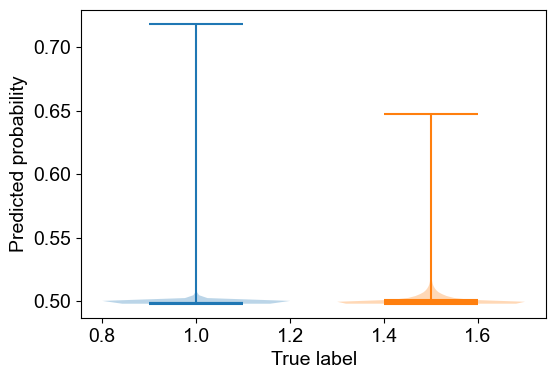

In [7]:
# plot distribution of positive and negative interactions
plt.figure(figsize=(6, 4))
plt.violinplot(proteomelm_scores[labels < threshold], widths=0.4, showmeans=True, showmedians=True)
plt.violinplot(proteomelm_scores[labels >= threshold], widths=0.4, showmeans=True, showmedians=True, positions=[1.5])
plt.xlabel("True label")
plt.ylabel("Predicted probability")

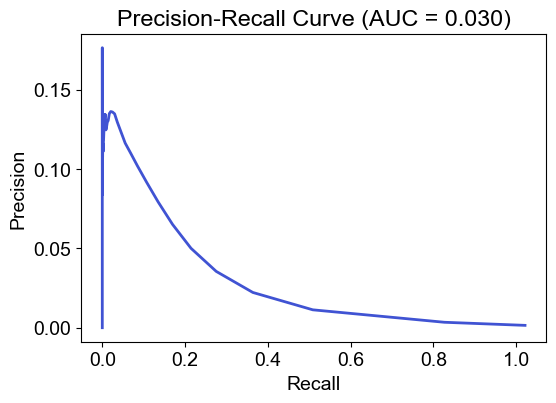

In [126]:
# plot the precision in function of the y_pred threshold 

x = np.linspace(1, 0., 1000)
prec = []
rec = []

for x_ in x:
    proteomelm_scores_binary = (proteomelm_scores >= x_).astype(int)
    tp = np.sum((proteomelm_scores_binary == 1) & (labels >= threshold))
    fp = np.sum((proteomelm_scores_binary == 1) & (labels < threshold))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    prec.append(precision)
    recall = tp / P if P > 0 else 0
    rec.append(recall)
auc_score = auc(rec, prec)
plt.figure(figsize=(6, 4))
plt.plot(rec, prec, color=colorspal6[0], linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AUC = {auc_score:.3f})")
plt.show()

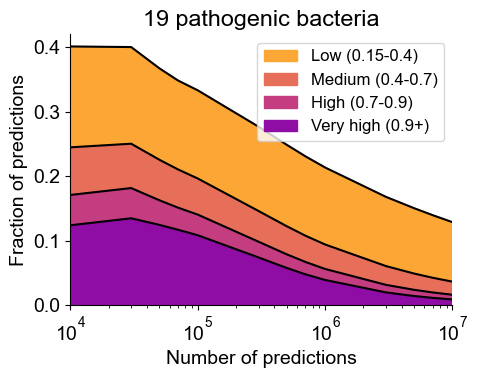

In [4]:
Ns = [10000, 30000, 50000, 70000, 100000, 300000, 500000, 700000, 1000000, 3000000, 5000000, 7000000, 10000000, 30000000, 50000000, 70000000, 100000000]
thrs = [150, 400, 700, 900]
suffix_name = "proteomelm-s"
thrs_labels = ["Low (0.15-0.4)", "Medium (0.4-0.7)", "High (0.7-0.9)", "Very high (0.9+)"]
indices = np.argsort(proteomelm_scores)[::-1]
y_sorted_by_proteomelm_score = labels[indices]
X = np.zeros((len(Ns), len(thrs)))
for i, n in enumerate(Ns):
    for j, thr in enumerate(thrs):
        X[i, j] = np.sum(y_sorted_by_proteomelm_score[:n] >= thr)/n
cmap = plt.get_cmap('plasma')
colors = [cmap(i) for i in np.linspace(0.3, 0.8, 4)][::-1]

plt.figure(figsize=(5, 4))
for i, thr in enumerate(thrs):
    plt.plot(Ns, X[:, i], color="black", linestyle="-")
    plt.fill_between(Ns, X[:, i], alpha=1, color=colors[i], label=thrs_labels[i])


plt.title(f"19 pathogenic bacteria")
plt.xscale("log")
plt.xlim(10000, 10000000)
plt.xlabel("Number of predictions")

plt.ylim(0, 0.42)
plt.ylabel("Fraction of predictions")
plt.legend(fontsize=12)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f"{env_dir}/fraction_above_threshold_pathogens_combined_{suffix_name}.svg", dpi=300)
plt.show()

In [7]:
scientific_name_dict = {
    272624: "L. pneumophila",
    169963: "L. monocytogenes",
    122586: "N. meningitidis",
    208964: "P. aeruginosa",
    871585: "A. pittii",
    177416: "F. tularensis",
    315277: "C. trachomatis",
    83333:  "E. coli",
    272563: "C. difficile",
    243273: "M. genitalium",
    171101: "S. pneumoniae",
    93061:  "S. aureus",
    295405: "B. fragilis",
    283166: "B. henselae",
    85962:  "H. pylori",
    632:    "Y. pestis",
    243277: "V. cholerae",
    83332:  "M. tuberculosis",
    99287:  "S. enterica"
}

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
threshold = 600
plt.figure(figsize=(5, 5))
for i, taxon_id in enumerate(proteomelm_scores_dict.keys()):
    y_pred_ = proteomelm_scores_dict[taxon_id]
    y_true_ = labels_dict[taxon_id] >= threshold
    fpr, tpr, _ = roc_curve(y_true_, y_pred_)
    auc_score = auc(fpr, tpr)
    print(f"Taxon {scientific_name_dict[taxon_id]} - AUC: {auc_score:.3f}, P: {np.sum(y_true_)}, N: {len(y_true_)}")

Taxon L. pneumophila - AUC: 0.715, P: 24292, N: 4326173
Taxon L. monocytogenes - AUC: 0.727, P: 28335, N: 4048402
Taxon N. meningitidis - AUC: 0.763, P: 12586, N: 2126926
Taxon P. aeruginosa - AUC: 0.730, P: 55769, N: 15515067
Taxon A. pittii - AUC: 0.736, P: 21404, N: 6474545
Taxon F. tularensis - AUC: 0.776, P: 10630, N: 1285593
Taxon C. trachomatis - AUC: 0.742, P: 7706, N: 399169
Taxon E. coli - AUC: 0.756, P: 44294, N: 8754939
Taxon C. difficile - AUC: 0.735, P: 28638, N: 7317162
Taxon M. genitalium - AUC: 0.696, P: 6381, N: 113047
Taxon S. pneumoniae - AUC: 0.751, P: 14570, N: 2094064
Taxon S. aureus - AUC: 0.760, P: 19480, N: 4180361
Taxon B. fragilis - AUC: 0.777, P: 27146, N: 10476661
Taxon B. henselae - AUC: 0.774, P: 11349, N: 1390262
Taxon H. pylori - AUC: 0.709, P: 13188, N: 1225383
Taxon Y. pestis - AUC: 0.734, P: 40254, N: 7552346
Taxon V. cholerae - AUC: 0.718, P: 45248, N: 7324801
Taxon M. tuberculosis - AUC: 0.703, P: 43368, N: 8106266
Taxon S. enterica - AUC: 0.731, 

<Figure size 500x500 with 0 Axes>

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Your reddish target RGB color (normalized)
target_color = (0.7098, 0.1137, 0.0784)

# Custom gradient: white → your color
custom_cmap = LinearSegmentedColormap.from_list("custom_red", [(1, 1, 1), target_color])

# Data
data = [
    ("L. pneumophila", 0.906, 2722, 4326173),
    ("L. monocytogenes", 0.905, 3081, 4048402),
    ("N. meningitidis", 0.921, 1941, 2126926),
    ("P. aeruginosa", 0.871, 4631, 15515067),
    ("A. pittii", 0.909, 1914, 6474545),
    ("F. tularensis", 0.937, 1877, 1285593),
    ("C. trachomatis", 0.888, 634, 399169),
    ("E. coli", 0.881, 5334, 8754939),
    ("C. difficile", 0.887, 2204, 7317162),
    ("M. genitalium", 0.889, 1830, 113047),
    ("S. pneumoniae", 0.860, 1300, 2094064),
    ("S. aureus", 0.923, 2361, 4180361),
    ("B. fragilis", 0.921, 999, 10476661),
    ("B. henselae", 0.922, 1747, 1390262),
    ("H. pylori", 0.881, 2190, 1225383),
    ("Y. pestis", 0.891, 3153, 7552346),
    ("V. cholerae", 0.902, 2182, 7324801),
    ("M. tuberculosis", 0.896, 3200, 8106266),
    ("S. enterica", 0.863, 4236, 9925643),
]


data = [("$\\it{{"+name+"}}$", auc, p, n) for name, auc, p, n in data]  

df = pd.DataFrame(data, columns=["Taxon", "AUC", "P", "N"])
df = df.sort_values("AUC")  # sort by AUC for nice plotting
#df["Taxon"] = df["Taxon"].apply(lambda name: rf"$\it{{{name}}}$")

# Normalize AUCs to [0,1] for colormap mapping
normed_auc = (df["AUC"] - 0.8) / (df["AUC"].max() - 0.8)
colors = custom_cmap(normed_auc)


In [ ]:

# Plot
plt.figure(figsize=(5, 8))
bars = plt.barh(df["Taxon"], df["AUC"], color=colors)

# Annotate with P and N counts
"""for i, (auc, p, n) in enumerate(zip(df["AUC"], df["P"], df["N"])):
    label = f"P: {p:,}\nN: {n:,}"
    plt.text(auc + 0.002, i, label, va='center', fontsize=8)"""

# Style
plt.xlabel("AUROC")
#plt.title("Per-taxon recovery of interactome", fontweight='bold')
plt.xlim(0.6, 0.95)
plt.ylim(-0.5, len(df) - 0.5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f"{env_dir}/string_auc_per_taxon.svg")
plt.show()


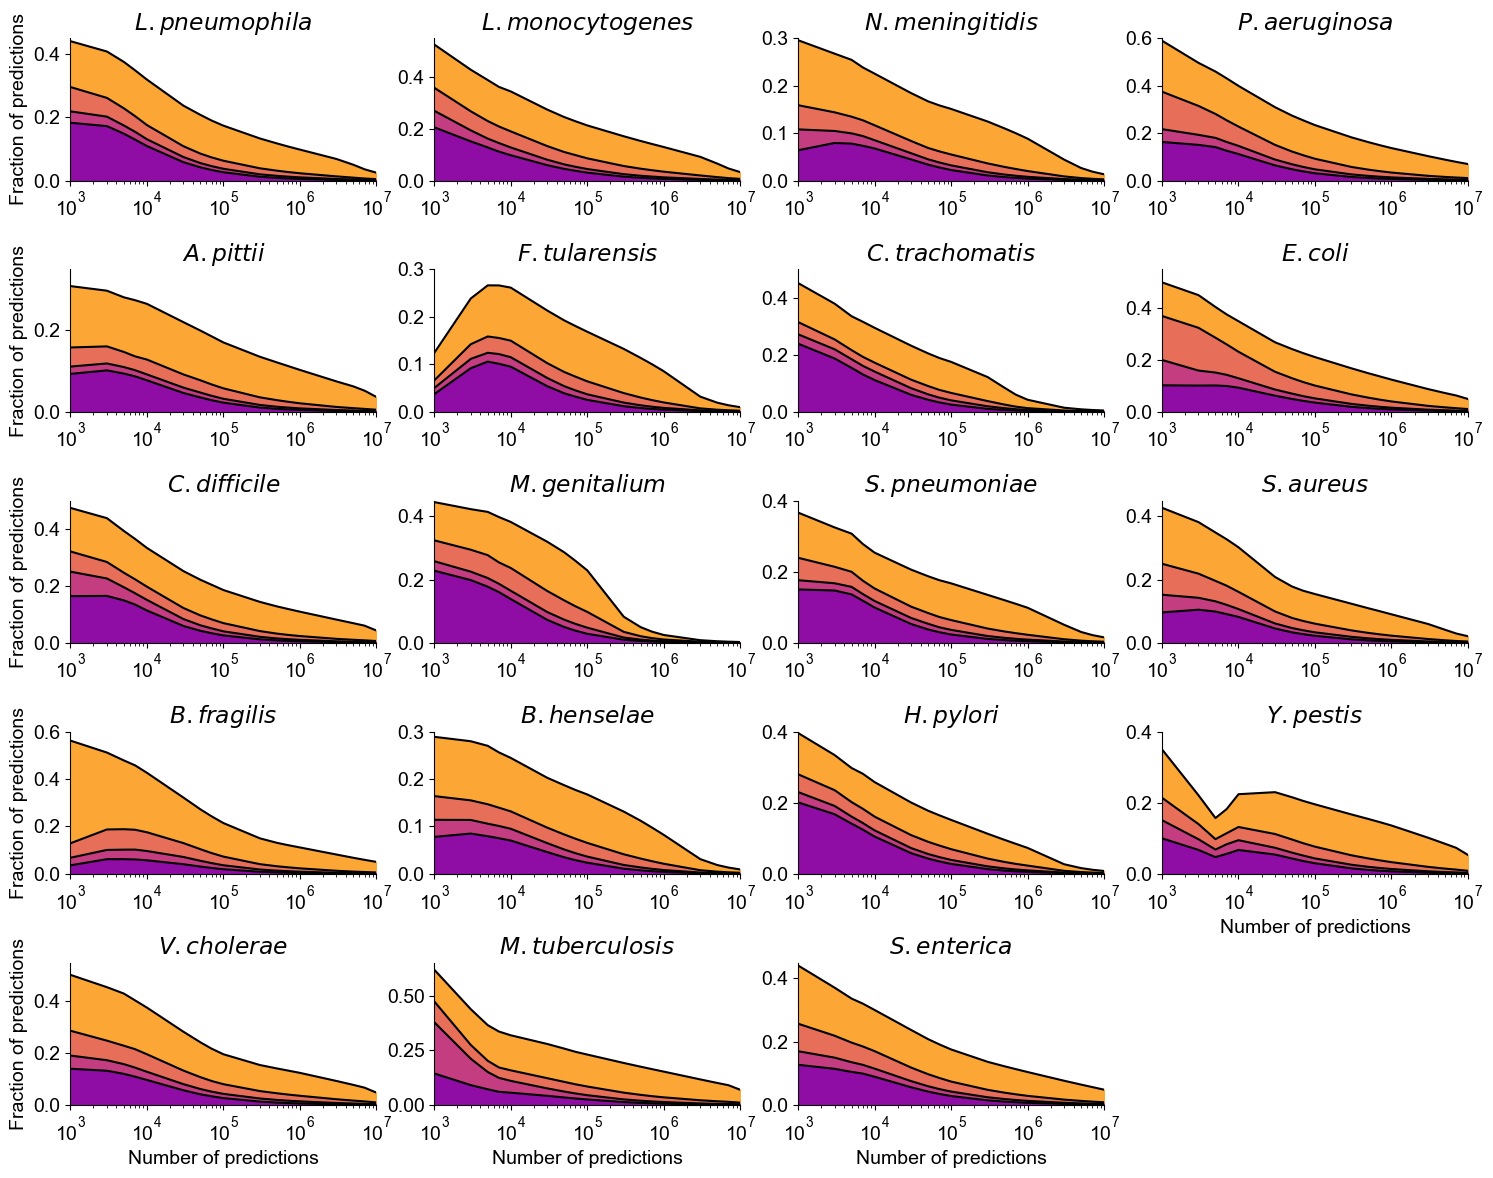

In [11]:
Ns = [1000, 3000, 5000, 7000, 10000, 30000, 50000, 70000, 100000, 300000, 500000, 700000, 1000000, 3000000, 5000000, 7000000, 10000000]
thrs = [150, 400, 700, 900]

suffix_name = ""

thrs_labels = ["low confidence (string < 150)", "medium confidence (string < 400)", "high confidence (string < 700)", "very high confidence (string < 900)"]
cmap = plt.get_cmap('plasma')
colors = [cmap(i) for i in np.linspace(0.3, 0.8, 4)][::-1]

plt.figure(figsize=(3*5, 3*4))
for i, taxon_id in enumerate(proteomelm_scores_dict.keys()):
    plt.subplot(5, 4, i + 1)
    if i >= 15:
        plt.xlabel("Number of predictions")
    if i % 4 == 0:
        plt.ylabel("Fraction of predictions")

    proteomelm_scores_ = proteomelm_scores_dict[taxon_id]
    indices = np.argsort(proteomelm_scores_)[::-1]
    labels_ = labels_dict[taxon_id]
    y_sorted_by_proteomelm_score = labels_[indices]
    X = np.zeros((len(Ns), len(thrs)))
    for i, n in enumerate(Ns):
        for j, thr in enumerate(thrs):
            X[i, j] = np.sum(y_sorted_by_proteomelm_score[:n] >= thr)/n

    for i, thr in enumerate(thrs):
        plt.plot(Ns, X[:, i], color="black", linestyle="-")
        plt.fill_between(Ns, X[:, i], alpha=1, color=colors[i], label=thrs_labels[i])
    plt.title(f"$\\it{{{scientific_name_dict[taxon_id]}}}$", fontweight="bold")
    plt.xscale("log")
    plt.xlim(1000, 10000000)
    M = (int(X[:, :].max() * 20) + 1 )/ 20.
    plt.ylim(0, M)
        
    #plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=12)

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f"{env_dir}/fraction_above_threshold_pathogens_{suffix_name}.svg", dpi=300)
plt.show()

KeyboardInterrupt: 

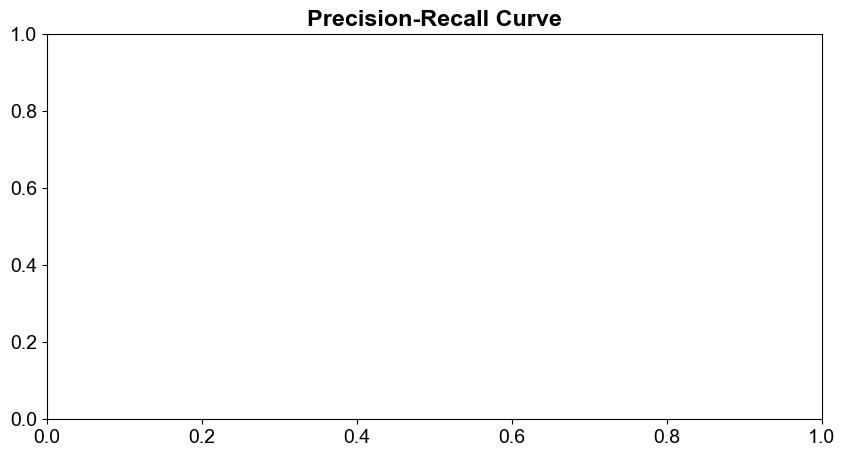

In [10]:
plt.figure(figsize=(10, 5))
plt.title("Precision-Recall Curve", fontweight="bold")
precision, recall, _ = precision_recall_curve(labels, proteomelm_scores)
plt.plot(recall, precision, label="ProteomeLM", color=colorspal6[0], linewidth=3)

dca_aupr = auc(x_dca, y_dca, )
rf2lite_aupr = auc(x_rf2lite, y_rf2lite)
af2_aupr = auc(x_af2, y_af2)
plt.plot(x_dca, y_dca, label="DCA", color=colorspal6[2], linewidth=3)
#plt.plot(x_rf2lite, y_rf2lite, label="RF2-Lite (AUPR: {:.3f})".format(rf2lite_aupr), color=colorspal6[3], linewidth=1)
#plt.plot(x_af2, y_af2, label="AlphaFold (AUPR: {:.3f})".format(af2_aupr), color=colorspal6[4], linewidth=1)
plt.xlabel("Recall")
plt.xlim(0, 1.05)

plt.ylabel("Precision")
plt.ylim(0, 0.15)

plt.legend(loc="lower right")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

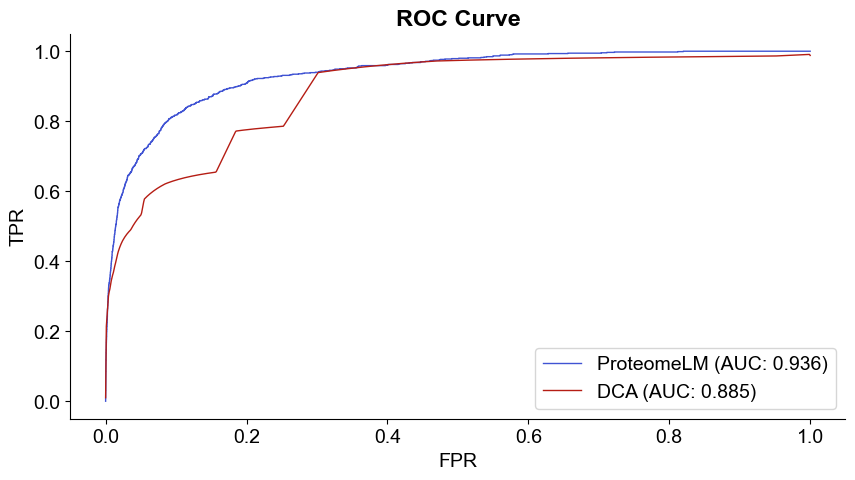

In [ ]:
from sklearn.metrics import roc_curve


plt.figure(figsize=(10, 5))
plt.title("ROC Curve", fontweight="bold")

fpr, tpr, _ = roc_curve(labels, proteomelm_scores)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label="ProteomeLM (AUC: {:.3f})".format(auc_score), color=colorspal6[0], linewidth=1)

fpr, tpr, auc_score = compute_fpr_tpr_auc(x_dca, y_dca, N, P)
plt.plot(fpr, tpr, label="DCA (AUC: {:.3f})".format(auc_score), color=colorspal6[2], linewidth=1)

# fpr, tpr, auc_score = compute_fpr_tpr_auc(x_rf2lite, y_rf2lite, N, p)
# plt.plot(fpr, tpr, label="RF2-Lite (AUC: {:.3f})".format(auc_score), color=colorspal6[3], linewidth=1)

# fpr, tpr, auc_score = compute_fpr_tpr_auc(x_af2, y_af2, N, p)
# plt.plot(fpr, tpr, label="AlphaFold (AUC: {:.3f})".format(auc_score), color=colorspal6[4], linewidth=1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")
# hide the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

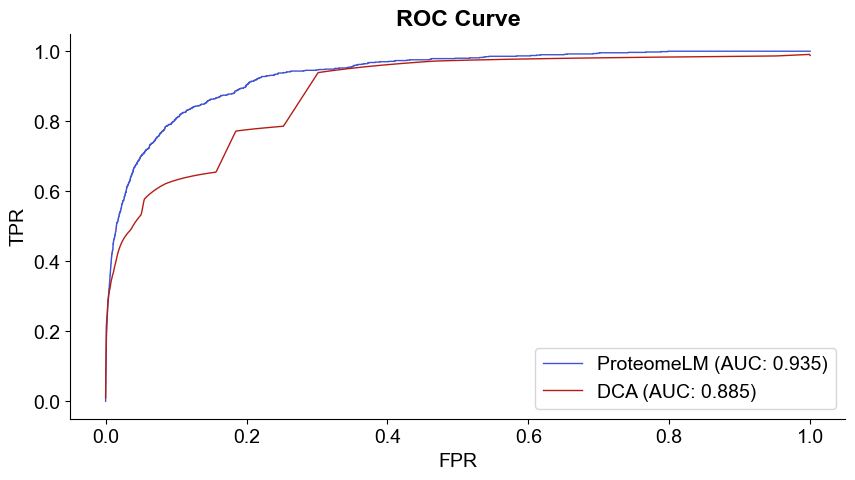

In [34]:
from sklearn.metrics import roc_curve


plt.figure(figsize=(10, 5))
plt.title("ROC Curve", fontweight="bold")

fpr, tpr, _ = roc_curve(labels, proteomelm_scores)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label="ProteomeLM (AUC: {:.3f})".format(auc_score), color=colorspal6[0], linewidth=1)

fpr, tpr, auc_score = compute_fpr_tpr_auc(x_dca, y_dca, N, P)
plt.plot(fpr, tpr, label="DCA (AUC: {:.3f})".format(auc_score), color=colorspal6[2], linewidth=1)

# fpr, tpr, auc_score = compute_fpr_tpr_auc(x_rf2lite, y_rf2lite, N, p)
# plt.plot(fpr, tpr, label="RF2-Lite (AUC: {:.3f})".format(auc_score), color=colorspal6[3], linewidth=1)

# fpr, tpr, auc_score = compute_fpr_tpr_auc(x_af2, y_af2, N, p)
# plt.plot(fpr, tpr, label="AlphaFold (AUC: {:.3f})".format(auc_score), color=colorspal6[4], linewidth=1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")
# hide the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

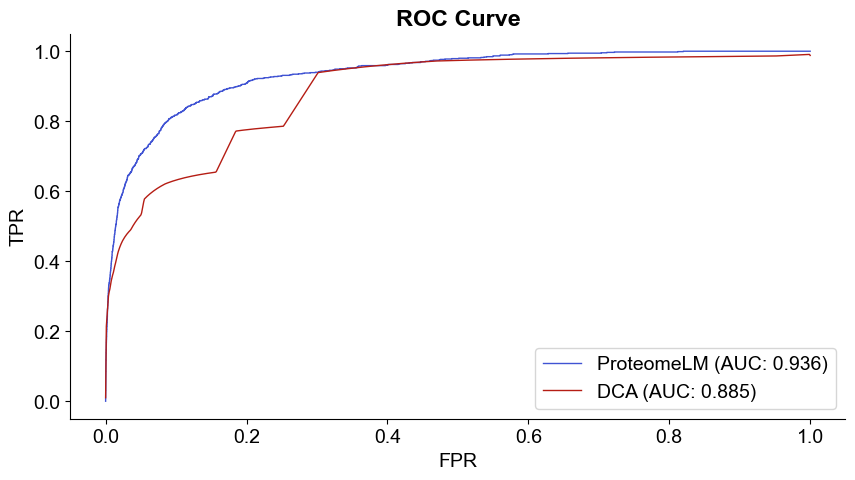

In [47]:
from sklearn.metrics import roc_curve


plt.figure(figsize=(10, 5))
plt.title("ROC Curve", fontweight="bold")

fpr, tpr, _ = roc_curve(labels, proteomelm_scores)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label="ProteomeLM (AUC: {:.3f})".format(auc_score), color=colorspal6[0], linewidth=1)

fpr, tpr, auc_score = compute_fpr_tpr_auc(x_dca, y_dca, N, P)
plt.plot(fpr, tpr, label="DCA (AUC: {:.3f})".format(auc_score), color=colorspal6[2], linewidth=1)

# fpr, tpr, auc_score = compute_fpr_tpr_auc(x_rf2lite, y_rf2lite, N, p)
# plt.plot(fpr, tpr, label="RF2-Lite (AUC: {:.3f})".format(auc_score), color=colorspal6[3], linewidth=1)

# fpr, tpr, auc_score = compute_fpr_tpr_auc(x_af2, y_af2, N, p)
# plt.plot(fpr, tpr, label="AlphaFold (AUC: {:.3f})".format(auc_score), color=colorspal6[4], linewidth=1)

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")
# hide the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
Ns = [10000, 30000, 50000, 70000, 100000, 300000, 500000, 700000, 1000000, 3000000, 5000000, 7000000, 10000000, 30000000, 50000000, 70000000, 100000000]
thrs = [150, 400, 700, 900]
thrs_labels = ["low confidence (string > 150)", "medium confidence (string > 400)", "high confidence (string > 700)", "very high confidence (string > 900)"]
X = np.zeros((len(Ns), len(thrs)))
for i, n in enumerate(Ns):
    for j, thr in enumerate(thrs):
        X[i, j] = np.sum(scores_sorted[:n] >= thr)/n

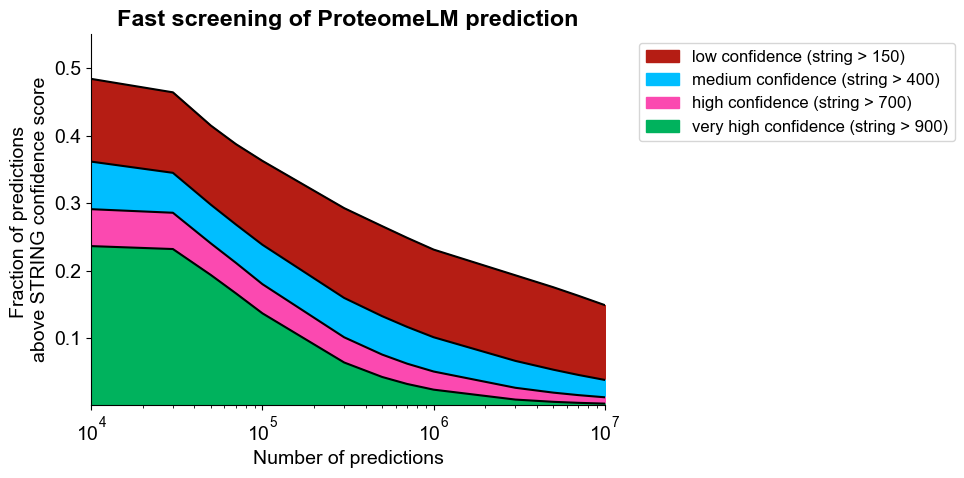

In [ ]:
plt.figure(figsize=(10, 5))
for i, thr in enumerate(thrs):
    plt.plot(Ns, X[:, i], color="black", linestyle="-")
    # fill below the curve
    plt.fill_between(Ns, X[:, i], alpha=1, color=colorspal6[i+2], label=thrs_labels[i])
plt.title("Fast screening of ProteomeLM prediction", fontweight="bold")
plt.xscale("log")
#plt.yscale("log")
plt.xlim(10000, 10000000)
plt.ylim(0.001, 0.55)
# put it outside
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=12)

plt.xlabel("Number of predictions")
plt.ylabel("Fraction of predictions \nabove STRING confidence score")
# remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(f"{env_dir}/fraction_above_threshold.svg", dpi=300)
plt.show()

Text(0.5, 1.0, 'ROC curve (AUC = 0.905)')

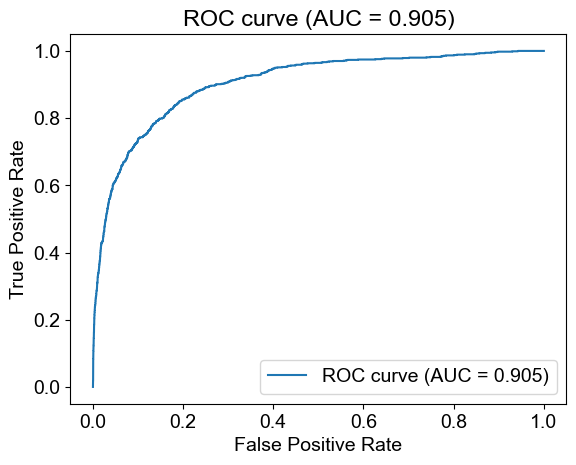

In [55]:
# draw the roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:0.3f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# log 
#plt.xscale("log")
plt.legend(loc="lower right")
plt.title("ROC curve (AUC = {:.3f})".format(roc_auc))